# WGAN with Gradien Penalty

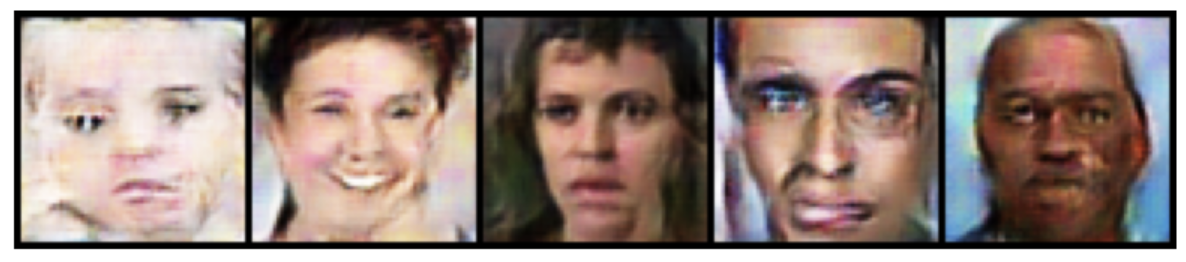

# Lowest FID: 58.72 at 110th epoch. At 215th epoch, the FID was 65.53 but the results were visually better than 110th epoch images.

In [1]:
# !pip install torch-fidelity

In [6]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR
import torchvision.utils as vutils
from torch_fidelity import calculate_metrics
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import os
import torchvision.utils as vutils
from torchvision.transforms.functional import resize

## We will start by studying the architecture of Deep Convolution GANs and then trying to implement it. The following is for Generator and the opposite is for Discriminator

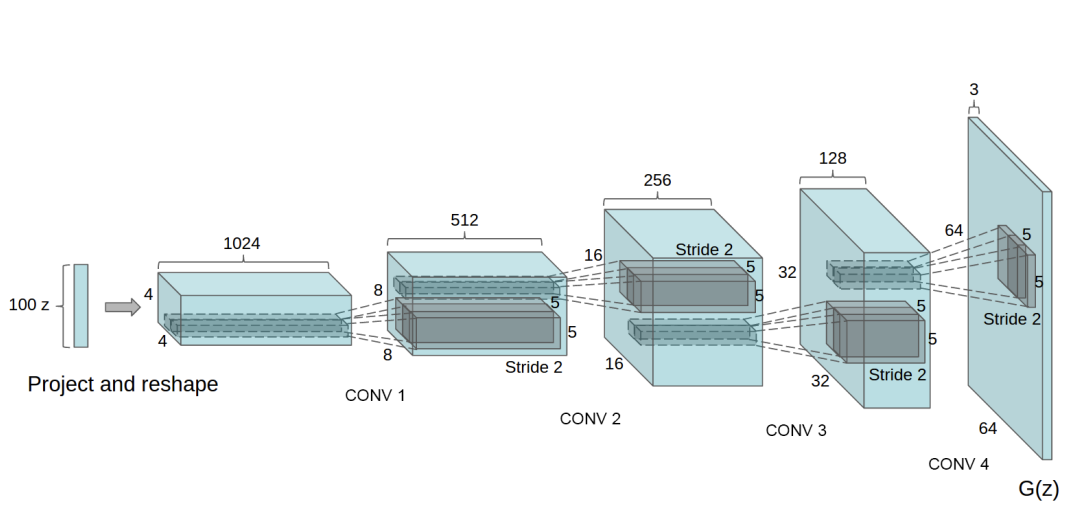

## We will also follow this architecture guideline to stablize the training conditions

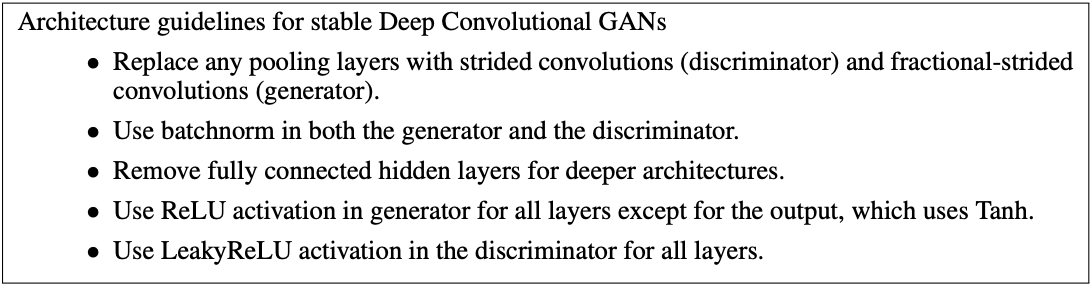

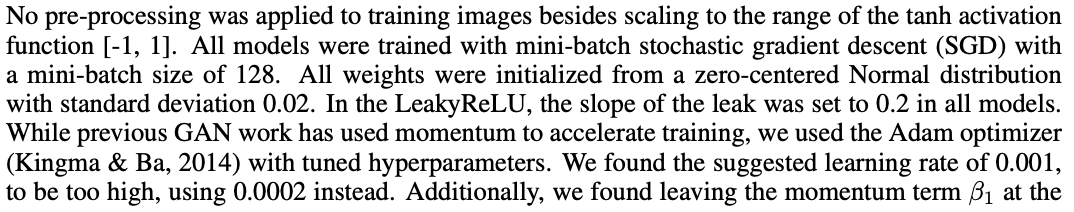

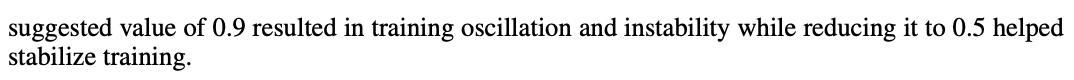

# Model Architecture

## Discriminator

In [7]:
class MyDiscriminator(nn.Module):
    def __init__(self, in_channels, k, s, p, b, leaky_slope):
        super(MyDiscriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels, 64, k, s, p),
            nn.LeakyReLU(leaky_slope), # Don't use batchnorm in first layer

            # Everything else follows the Convolution architecture in above figure.    
            nn.Sequential(
                nn.Conv2d(64, 128, k, s, p, bias=b),
                # Layer Normalization instead of batch normalization
                # From wgan with gradient penalty paper
                nn.InstanceNorm2d(128, affine=True), 
                nn.LeakyReLU(leaky_slope), # LeakyRelu for discriminator, ReLU for Generator
            ),

            nn.Sequential(
                nn.Conv2d(128, 256, k, s, p, bias=b),
                nn.InstanceNorm2d(256, affine=True), 
                nn.LeakyReLU(leaky_slope),
            ),

            nn.Sequential(
                nn.Conv2d(256, 512, k, s, p, bias=b),
                nn.InstanceNorm2d(512, affine=True),
                nn.LeakyReLU(leaky_slope),
            ),

            nn.Conv2d(512, 1, k, s, padding=0),
        )
        

    def forward(self, x):
        return self.discriminator(x)        
        

## Generator

In [8]:
class MyGenerator(nn.Module):
    def __init__(self, gen_initial_dim, in_channels, k, s, p, b):
        super(MyGenerator, self).__init__()

        self.generator = nn.Sequential(
            nn.Sequential(
                nn.ConvTranspose2d(gen_initial_dim, 1024, k, s, padding=0, bias=b),
                nn.BatchNorm2d(1024), # BatchNorm for Gen
                nn.ReLU()
            ),

            nn.Sequential(
                nn.ConvTranspose2d(1024, 512, k, s, p, bias=b),
                nn.BatchNorm2d(512),
                nn.ReLU()
            ),
            
            nn.Sequential(
                nn.ConvTranspose2d(512, 256, k, s, p, bias=b),
                nn.BatchNorm2d(256),
                nn.ReLU()
            ),
            
            nn.Sequential(
                nn.ConvTranspose2d(256, 128, k, s, p, bias=b),
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),

            nn.ConvTranspose2d(128, in_channels, k, s, p),
            nn.Tanh(),
        )


    def forward(self, x):
        return self.generator(x)

## Weight Initialization (Zero-Centered Normal Distribution with SD of 0.02)

In [9]:
test_disc = MyDiscriminator(3, 8, 4, 2, 1, False, 0.02) # leaky relu with slope 0.2
# hyperparameters are from the improved gan paper
[type(x) for x in test_disc.modules()]

[__main__.MyDiscriminator,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.activation.LeakyReLU,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.instancenorm.InstanceNorm2d,
 torch.nn.modules.activation.LeakyReLU,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.instancenorm.InstanceNorm2d,
 torch.nn.modules.activation.LeakyReLU,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.instancenorm.InstanceNorm2d,
 torch.nn.modules.activation.LeakyReLU,
 torch.nn.modules.conv.Conv2d]

### For every Conv2d, ConvTranspose2d, and BatchNorm2d, we will initialize from weight distribution of M:0, SD:0.02

In [10]:
def assign_normalized_weights(model):
    return nn.init.normal_(model.weight.data, 0.0, 0.02) # m:0, SD:0.02 Weights are normalized 
    
def weights_initializer(m):
    for model in m.modules(): # For every layer of conv and normalized layers
        if isinstance(model, nn.Conv2d):
            assign_normalized_weights(model)
        elif isinstance(model, nn.BatchNorm2d):
            assign_normalized_weights(model)
        elif isinstance(model, nn.ConvTranspose2d):
            assign_normalized_weights(model)

In [11]:
d = torch.randn((8, 3, 64, 64))
weights_initializer(test_disc)
test_disc(d).shape

torch.Size([8, 1, 1, 1])

#### Expected shape (batch_size, 1, 1, 1) -> 1x1 image size

In [12]:
test_gen = MyGenerator(50, 3, 8, 4, 2, 1, False)
d = torch.randn((8, 50, 1, 1))
weights_initializer(test_gen)
test_gen(d).shape

torch.Size([8, 3, 64, 64])

#### Expected shape (batch_size, inp_dim, height, width)

### Okay, it works!!

# Params

In [13]:
params = { # All the hyperparameters are taken from the improved WGAN training paper
    "batch_size": 64, 
    "gen_initial_dimension": 100, 
    "input_channels": 3, # image channels
    
    "out_channels_gen": 64,
    "kernel_gen": 4,
    "stride_gen": 2,
    "pad_gen": 1,
    "bias_gen": False, # Cuz normalizing in next steo
    "learning_rate_gen": 0.0004,
    
    "out_channels_dis": 64,
    "kernel_dis": 4, # Why 4? Even in cycleGAN official repo, they said they followed DCGAN paper.
    "stride_dis": 2,
    "pad_dis": 1,
    "bias_dis": False,
    "leaky_relu_slope": 0.2,
    "learning_rate_dis": 0.0004,
    "dis_extention_factor": 5,
    "lambda": 10,

    "num_epochs": 226,    
}

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Loading and preprocessing:

## Transfomations using torchvision

In [15]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    # Normalized with the mean between -0.5 to 0.5 and SD between -1 to 1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

## Image DataLoaders

In [16]:
dataset = datasets.ImageFolder(root="/kaggle/input/facesexp/data/faces", transform=transform)
dataloader = DataLoader(dataset, batch_size = params["batch_size"], shuffle=True)

# Generator and Discriminator objects and settings

In [17]:
my_generator = MyGenerator(
    params["gen_initial_dimension"], 
    params["input_channels"],
    params["kernel_gen"],
    params["stride_gen"],
    params["pad_gen"],
    params["bias_gen"]
).to(device)


weights_initializer(my_generator)
optimizer_gen = optim.Adam(my_generator.parameters(), lr=params["learning_rate_gen"], betas=(0.0, 0.9))
# scheduler_gen = ExponentialLR(optimizer_gen, gamma=0.9) 

In [18]:
my_discriminator = MyDiscriminator(
    params["input_channels"],
    params["kernel_dis"],
    params["stride_dis"],
    params["pad_dis"],
    params["bias_dis"],
    params["leaky_relu_slope"]
).to(device)

weights_initializer(my_discriminator)
optimizer_dis = optim.Adam(my_discriminator.parameters(), lr=params["learning_rate_dis"], betas=(0.0, 0.9))
# scheduler_dis = ExponentialLR(optimizer_dis, gamma=0.9)

In [19]:
# Tensorboard 20 images
init_noise_dim = params["gen_initial_dimension"]
gen_initial_noise_tb = torch.randn((20, init_noise_dim, 1, 1)).to(device)

# Training

In [20]:
tensorboard_writer_dis = SummaryWriter(f"/kaggle/working/logs/final/dis")
tensorboard_writer_gen = SummaryWriter(f"/kaggle/working/logs/final/gen")
log_step = 0

## Computing Gradient Penalty to add to discriminator loss

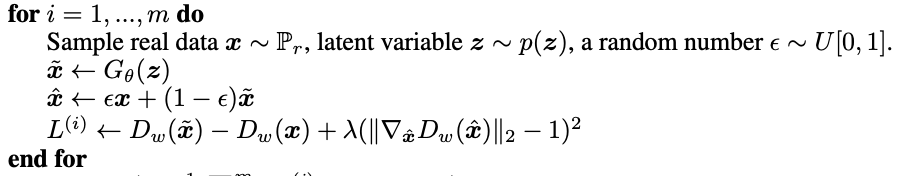

In [21]:
def calc_gp(discriminator, real_data, fake_data, device='cpu'):
    ep = torch.rand(real_data.shape[0], 1, 1, 1, device=device) # Random number for shape
    
    # this is x_dash from above let's say 60% of real face then add 40% of fake image to interpolate
    interpolated_faces = (ep * real_data + ((1 - ep) * fake_data)).requires_grad_(True)
    
    interpolated_faces_scores = discriminator(interpolated_faces) #Score from critic
    # Gradient outputs for gradients which is filled with ones values, requiremtn for autograd.grad
    grad_outputs = torch.ones(interpolated_faces_scores.shape, device=device, requires_grad=False)
    
    # gradient calc for critics score wrt the interpolated images
    gradients = torch.autograd.grad(
        outputs=interpolated_faces_scores,
        inputs=interpolated_faces,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True, # we still need to compute the norm of these gradients as seen in formula.
                           # Pytorch will clear these gradients and we cannot compute norm. SO we retain
    )[0]
    
    gradients = gradients.view(gradients.shape[0], -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()  #NORM as in formula and then minus and squared as seen.

In [22]:
my_discriminator.train()
# We train discriminator more in wgan
def train_discriminator(real_data):
    for _ in range(params["dis_extention_factor"]):
        my_discriminator.zero_grad()
        gen_input_noise = torch.randn(real_data.shape[0], params["gen_initial_dimension"], 1, 1, device=device)
        fake_data = my_generator(gen_input_noise)
        
        prediction_real = my_discriminator(real_data).reshape(-1)    
        prediction_fake = my_discriminator(fake_data).reshape(-1)

        gp = calc_gp(my_discriminator, real_data, fake_data, device=device)
        avg_prediction_real = torch.mean(prediction_real)
        avg_prediction_fake = torch.mean(prediction_fake)
        loss = (-(avg_prediction_real - avg_prediction_fake) + params["lambda"] * gp)
        loss.backward(retain_graph=True)
        optimizer_dis.step()
    
    return loss, fake_data

In [23]:
my_generator.train()
def train_generator(fake_data):
    my_generator.zero_grad()
    prediction = my_discriminator(fake_data).reshape(-1)

    loss = -torch.mean(prediction)
    loss.backward()
    optimizer_gen.step()

    return loss

In [24]:
len(dataloader)

223

In [25]:
# !rm -rf /kaggle/workindg/checkpoint_epo*

In [26]:
# !rm -rf /kaggle/working/

## Checkpoints and loading

In [27]:
checkpoint_path = "/kaggle/working/ckpts/checkpoint_epoch_215.pt"  
import os
if os.path.isfile(checkpoint_path):
    print(f"Loading checkpoint '{checkpoint_path}'")
    checkpoint = torch.load(checkpoint_path)
    
    my_generator.load_state_dict(checkpoint['generator_state_dict'])
    my_discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    
    optimizer_gen.load_state_dict(checkpoint['optimizer_gen_state_dict'])
    optimizer_dis.load_state_dict(checkpoint['optimizer_dis_state_dict'])
    
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 0

Loading checkpoint '/kaggle/working/ckpts/checkpoint_epoch_215.pt'
Checkpoint loaded. Resuming training from epoch 216.


# Training and saving loop

In [97]:
for epoch in range(start_epoch, params["num_epochs"]):
    for batch, (real_data, _) in enumerate(tqdm(dataloader)):
        real_data = real_data.to(device)
        
        loss_dis, fake_data = train_discriminator(real_data)
        loss_gen = train_generator(fake_data)
        
        if batch % 50 == 0:
            print(f"Epoch [{epoch}/{params['num_epochs']}] Batch {batch}/{len(dataloader)} \
                  Loss Dis: {loss_dis:.4f}, loss Gen: {loss_gen:.4f}")

            with torch.no_grad():
                fake_data_tb = my_generator(gen_initial_noise_tb)
                tensorboard_writer_dis.add_image("Real Faces", make_grid(real_data[:20], normalize=True), global_step=log_step)
                tensorboard_writer_gen.add_image("Fake Faces", make_grid(fake_data_tb[:20], normalize=True), global_step=log_step)

                log_step += 1
    
    if epoch % 5 == 0:
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': my_generator.state_dict(),
            'discriminator_state_dict': my_discriminator.state_dict(),
            'optimizer_gen_state_dict': optimizer_gen.state_dict(),
            'optimizer_dis_state_dict': optimizer_dis.state_dict(),
        }

        checkpoint_path = f"/kaggle/working/ckpts/checkpoint_epoch_{epoch}.pt"
        torch.save(checkpoint, checkpoint_path)

  0%|          | 1/223 [00:02<09:29,  2.57s/it]

Epoch [216/226] Batch 0/223                   Loss Dis: -11.0146, loss Gen: -45.5631


 23%|██▎       | 51/223 [01:08<04:06,  1.43s/it]

Epoch [216/226] Batch 50/223                   Loss Dis: -9.3357, loss Gen: -45.4116


 45%|████▌     | 101/223 [02:16<03:06,  1.53s/it]

Epoch [216/226] Batch 100/223                   Loss Dis: -9.2761, loss Gen: -45.3017


 68%|██████▊   | 151/223 [03:23<01:37,  1.36s/it]

Epoch [216/226] Batch 150/223                   Loss Dis: -11.0676, loss Gen: -45.9624


 90%|█████████ | 201/223 [04:30<00:31,  1.43s/it]

Epoch [216/226] Batch 200/223                   Loss Dis: -11.9183, loss Gen: -46.0565


  0%|          | 1/223 [00:01<04:36,  1.25s/it]

Epoch [217/226] Batch 0/223                   Loss Dis: -11.7534, loss Gen: -46.4840


 23%|██▎       | 51/223 [00:45<02:54,  1.01s/it]

Epoch [217/226] Batch 50/223                   Loss Dis: -15.1464, loss Gen: -49.4466


 45%|████▌     | 101/223 [01:29<01:52,  1.08it/s]

Epoch [217/226] Batch 100/223                   Loss Dis: -12.3453, loss Gen: -41.5238


 68%|██████▊   | 151/223 [02:12<01:09,  1.04it/s]

Epoch [217/226] Batch 150/223                   Loss Dis: -9.1493, loss Gen: -46.1415


 90%|█████████ | 201/223 [02:55<00:20,  1.09it/s]

Epoch [217/226] Batch 200/223                   Loss Dis: -9.5230, loss Gen: -40.7998


  0%|          | 1/223 [00:01<04:41,  1.27s/it]

Epoch [218/226] Batch 0/223                   Loss Dis: -12.4336, loss Gen: -48.7191


 23%|██▎       | 51/223 [00:45<03:05,  1.08s/it]

Epoch [218/226] Batch 50/223                   Loss Dis: -7.9541, loss Gen: -44.2812


 45%|████▌     | 101/223 [01:29<01:58,  1.03it/s]

Epoch [218/226] Batch 100/223                   Loss Dis: -10.5231, loss Gen: -46.0641


 68%|██████▊   | 151/223 [02:13<01:10,  1.02it/s]

Epoch [218/226] Batch 150/223                   Loss Dis: -9.9702, loss Gen: -49.9983


 90%|█████████ | 201/223 [02:56<00:21,  1.05it/s]

Epoch [218/226] Batch 200/223                   Loss Dis: -11.6555, loss Gen: -46.8002


  0%|          | 1/223 [00:01<04:20,  1.17s/it]

Epoch [219/226] Batch 0/223                   Loss Dis: -10.4771, loss Gen: -44.9591


 23%|██▎       | 51/223 [00:44<02:37,  1.09it/s]

Epoch [219/226] Batch 50/223                   Loss Dis: -11.8358, loss Gen: -46.0883


 45%|████▌     | 101/223 [01:27<01:59,  1.02it/s]

Epoch [219/226] Batch 100/223                   Loss Dis: -8.5329, loss Gen: -45.7018


 68%|██████▊   | 151/223 [02:12<01:08,  1.06it/s]

Epoch [219/226] Batch 150/223                   Loss Dis: -9.6352, loss Gen: -44.5718


 90%|█████████ | 201/223 [02:57<00:21,  1.02it/s]

Epoch [219/226] Batch 200/223                   Loss Dis: -11.8377, loss Gen: -47.9721


  0%|          | 1/223 [00:01<04:43,  1.28s/it]

Epoch [220/226] Batch 0/223                   Loss Dis: -10.1967, loss Gen: -42.9243


 23%|██▎       | 51/223 [00:44<02:49,  1.02it/s]

Epoch [220/226] Batch 50/223                   Loss Dis: -7.4972, loss Gen: -47.3356


 45%|████▌     | 101/223 [01:28<02:00,  1.01it/s]

Epoch [220/226] Batch 100/223                   Loss Dis: -9.8274, loss Gen: -43.0769


 68%|██████▊   | 151/223 [02:12<01:08,  1.05it/s]

Epoch [220/226] Batch 150/223                   Loss Dis: -12.6785, loss Gen: -45.6626


 90%|█████████ | 201/223 [02:56<00:21,  1.03it/s]

Epoch [220/226] Batch 200/223                   Loss Dis: -12.9154, loss Gen: -45.4311


  0%|          | 1/223 [00:01<04:37,  1.25s/it]

Epoch [221/226] Batch 0/223                   Loss Dis: -8.7944, loss Gen: -41.6319


 23%|██▎       | 51/223 [00:45<02:41,  1.06it/s]

Epoch [221/226] Batch 50/223                   Loss Dis: -11.4611, loss Gen: -42.5811


 45%|████▌     | 101/223 [01:28<01:56,  1.05it/s]

Epoch [221/226] Batch 100/223                   Loss Dis: -11.8119, loss Gen: -39.9253


 68%|██████▊   | 151/223 [02:12<01:13,  1.02s/it]

Epoch [221/226] Batch 150/223                   Loss Dis: -11.8698, loss Gen: -43.7009


 90%|█████████ | 201/223 [02:57<00:22,  1.01s/it]

Epoch [221/226] Batch 200/223                   Loss Dis: -10.7237, loss Gen: -41.1944


  0%|          | 1/223 [00:01<04:25,  1.20s/it]

Epoch [222/226] Batch 0/223                   Loss Dis: -10.8404, loss Gen: -39.4199


 23%|██▎       | 51/223 [00:44<02:42,  1.06it/s]

Epoch [222/226] Batch 50/223                   Loss Dis: -8.3736, loss Gen: -40.5571


 45%|████▌     | 101/223 [01:29<01:57,  1.04it/s]

Epoch [222/226] Batch 100/223                   Loss Dis: -8.5456, loss Gen: -42.2106


 68%|██████▊   | 151/223 [02:13<01:05,  1.10it/s]

Epoch [222/226] Batch 150/223                   Loss Dis: -8.7889, loss Gen: -43.9228


 90%|█████████ | 201/223 [02:56<00:22,  1.01s/it]

Epoch [222/226] Batch 200/223                   Loss Dis: -8.3913, loss Gen: -39.6056


  0%|          | 1/223 [00:01<04:00,  1.08s/it]

Epoch [223/226] Batch 0/223                   Loss Dis: -9.0620, loss Gen: -43.3572


 23%|██▎       | 51/223 [00:46<02:53,  1.01s/it]

Epoch [223/226] Batch 50/223                   Loss Dis: -11.2233, loss Gen: -43.0596


 45%|████▌     | 101/223 [01:29<01:55,  1.06it/s]

Epoch [223/226] Batch 100/223                   Loss Dis: -9.3942, loss Gen: -38.5589


 68%|██████▊   | 151/223 [02:13<01:13,  1.03s/it]

Epoch [223/226] Batch 150/223                   Loss Dis: -13.6099, loss Gen: -41.6220


 90%|█████████ | 201/223 [02:56<00:20,  1.05it/s]

Epoch [223/226] Batch 200/223                   Loss Dis: -7.2295, loss Gen: -43.6797


  0%|          | 1/223 [00:01<05:06,  1.38s/it]

Epoch [224/226] Batch 0/223                   Loss Dis: -10.8753, loss Gen: -40.6396


 23%|██▎       | 51/223 [00:44<02:36,  1.10it/s]

Epoch [224/226] Batch 50/223                   Loss Dis: -9.4944, loss Gen: -40.8199


 45%|████▌     | 101/223 [01:29<01:52,  1.09it/s]

Epoch [224/226] Batch 100/223                   Loss Dis: -12.4371, loss Gen: -43.6586


 68%|██████▊   | 151/223 [02:12<01:14,  1.03s/it]

Epoch [224/226] Batch 150/223                   Loss Dis: -8.6770, loss Gen: -39.0205


 90%|█████████ | 201/223 [02:57<00:22,  1.03s/it]

Epoch [224/226] Batch 200/223                   Loss Dis: -8.6462, loss Gen: -38.6774


  0%|          | 1/223 [00:01<03:58,  1.08s/it]

Epoch [225/226] Batch 0/223                   Loss Dis: -8.3154, loss Gen: -35.5618


 23%|██▎       | 51/223 [00:45<02:35,  1.11it/s]

Epoch [225/226] Batch 50/223                   Loss Dis: -8.2967, loss Gen: -42.5990


 45%|████▌     | 101/223 [01:29<01:52,  1.09it/s]

Epoch [225/226] Batch 100/223                   Loss Dis: -11.2237, loss Gen: -40.8761


 68%|██████▊   | 151/223 [02:13<01:05,  1.09it/s]

Epoch [225/226] Batch 150/223                   Loss Dis: -9.1021, loss Gen: -37.9666


 90%|█████████ | 201/223 [02:56<00:21,  1.01it/s]

Epoch [225/226] Batch 200/223                   Loss Dis: -13.8286, loss Gen: -41.6901


100%|██████████| 223/223 [03:15<00:00,  1.14it/s]


In [124]:
# !rm -rf /kaggle/working/dir*

In [2]:
# !zip -r file.zip /kaggle/working/logs/

  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/wgangpp/ (stored 0%)
  adding: kaggle/working/logs/wgangpp/gen/ (stored 0%)
  adding: kaggle/working/logs/wgangpp/gen/events.out.tfevents.1711337672.608b727c107c.34.1 (deflated 0%)
  adding: kaggle/working/logs/wgangpp/gen/events.out.tfevents.1711341507.608b727c107c.34.3 (deflated 0%)
  adding: kaggle/working/logs/wgangpp/gen/events.out.tfevents.1711335285.225273c2ffbb.121.1 (deflated 0%)
  adding: kaggle/working/logs/wgangpp/dis/ (stored 0%)
  adding: kaggle/working/logs/wgangpp/dis/events.out.tfevents.1711341507.608b727c107c.34.2 (deflated 0%)
  adding: kaggle/working/logs/wgangpp/dis/events.out.tfevents.1711335285.225273c2ffbb.121.0 (deflated 0%)
  adding: kaggle/working/logs/wgangpp/dis/events.out.tfevents.1711337672.608b727c107c.34.0 (deflated 0%)
  adding: kaggle/working/logs/wgangp/ (stored 0%)
  adding: kaggle/working/logs/wgangp/gen/ (stored 0%)
  adding: kaggle/working/logs/wgangp/gen/events.out.tfevents

In [3]:
# !ls

checkpoint_epoch_0.pt	checkpoint_epoch_26.pt	checkpoint_epoch_44.pt
checkpoint_epoch_10.pt	checkpoint_epoch_28.pt	checkpoint_epoch_46.pt
checkpoint_epoch_12.pt	checkpoint_epoch_30.pt	checkpoint_epoch_48.pt
checkpoint_epoch_14.pt	checkpoint_epoch_32.pt	checkpoint_epoch_50.pt
checkpoint_epoch_16.pt	checkpoint_epoch_34.pt	checkpoint_epoch_6.pt
checkpoint_epoch_18.pt	checkpoint_epoch_36.pt	checkpoint_epoch_8.pt
checkpoint_epoch_2.pt	checkpoint_epoch_38.pt	file.zip
checkpoint_epoch_20.pt	checkpoint_epoch_4.pt	logs
checkpoint_epoch_22.pt	checkpoint_epoch_40.pt
checkpoint_epoch_24.pt	checkpoint_epoch_42.pt


In [35]:
# !mkdir /kaggle/working/ckpts
# !mv /kaggle/working/ch* /kaggle/working/ckpts/

# Evaluations and LOGS for tensorboard

In [2]:
noise_dim = 100 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generated_images_dir = "generated_images/"

writer = SummaryWriter('logs/wgan_metrics') #tensorboard

def load_checkpoint(checkpoint_path, model): # load the generator state dict
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['generator_state_dict'])

checkpoints_dir = "/kaggle/working/ckpts"
checkpoints = sorted( # Sort in 0, 1, 2 order
    os.listdir(checkpoints_dir), 
    key=lambda x: int(x.split('_')[-1].split('.')[0])
)

for checkpoint_name in checkpoints:
    if not checkpoint_name.endswith('.pt'): # for few of all the ckpts 
        continue

    epoch = int(checkpoint_name.split('_')[-1].split('.')[0])  # extract epoch from filename
    checkpoint_path = os.path.join(checkpoints_dir, checkpoint_name)
    print(f"EPOCH: {epoch}")

    load_checkpoint(checkpoint_path, my_generator)
    my_generator.eval()

    os.system(f'rm -rf {generated_images_dir}*') # fresh

    os.makedirs(generated_images_dir, exist_ok=True)
    with torch.no_grad():
        noise = torch.randn(2048, noise_dim, 1, 1, device=device) # have to match 2048 dimension from inception model 
        generated_images = my_generator(noise)
        for i, image in enumerate(generated_images):
            image = resize(image, [64, 64])
            vutils.save_image(image, f"{generated_images_dir}/{i:05d}.png", normalize=True)

    real_images_dir = "/kaggle/input/facesresized/faces_resized" # resized real faces too
    metrics = calculate_metrics(input1=generated_images_dir, input2=real_images_dir, isc=True, fid=True, cuda=True)
    
    # Tensorboard logs
    writer.add_scalar("Inception_Score", metrics['inception_score_mean'], epoch)
    writer.add_scalar("FID", metrics['frechet_inception_distance'], epoch)

    print(f"Epoch {epoch}: IS = {metrics['inception_score_mean']}, FID = {metrics['frechet_inception_distance']}")

    for name, param in my_generator.named_parameters():
        writer.add_histogram(f"Generator_weights/{name}", param, epoch)
        if param.grad is not None:
            writer.add_histogram(f"Generator_gradients/{name}", param.grad, epoch)

    fixed_noise = torch.randn(30, noise_dim, 1, 1, device=device)
    fixed_generated_images = my_generator(fixed_noise)
    fixed_img_grid = make_grid(fixed_generated_images, normalize=True)
    writer.add_image("Fixed_generated_images", fixed_img_grid, epoch)

writer.close()


## FID score did drop from a high value and after 75-80 epoch, there is not much sign of it going down.

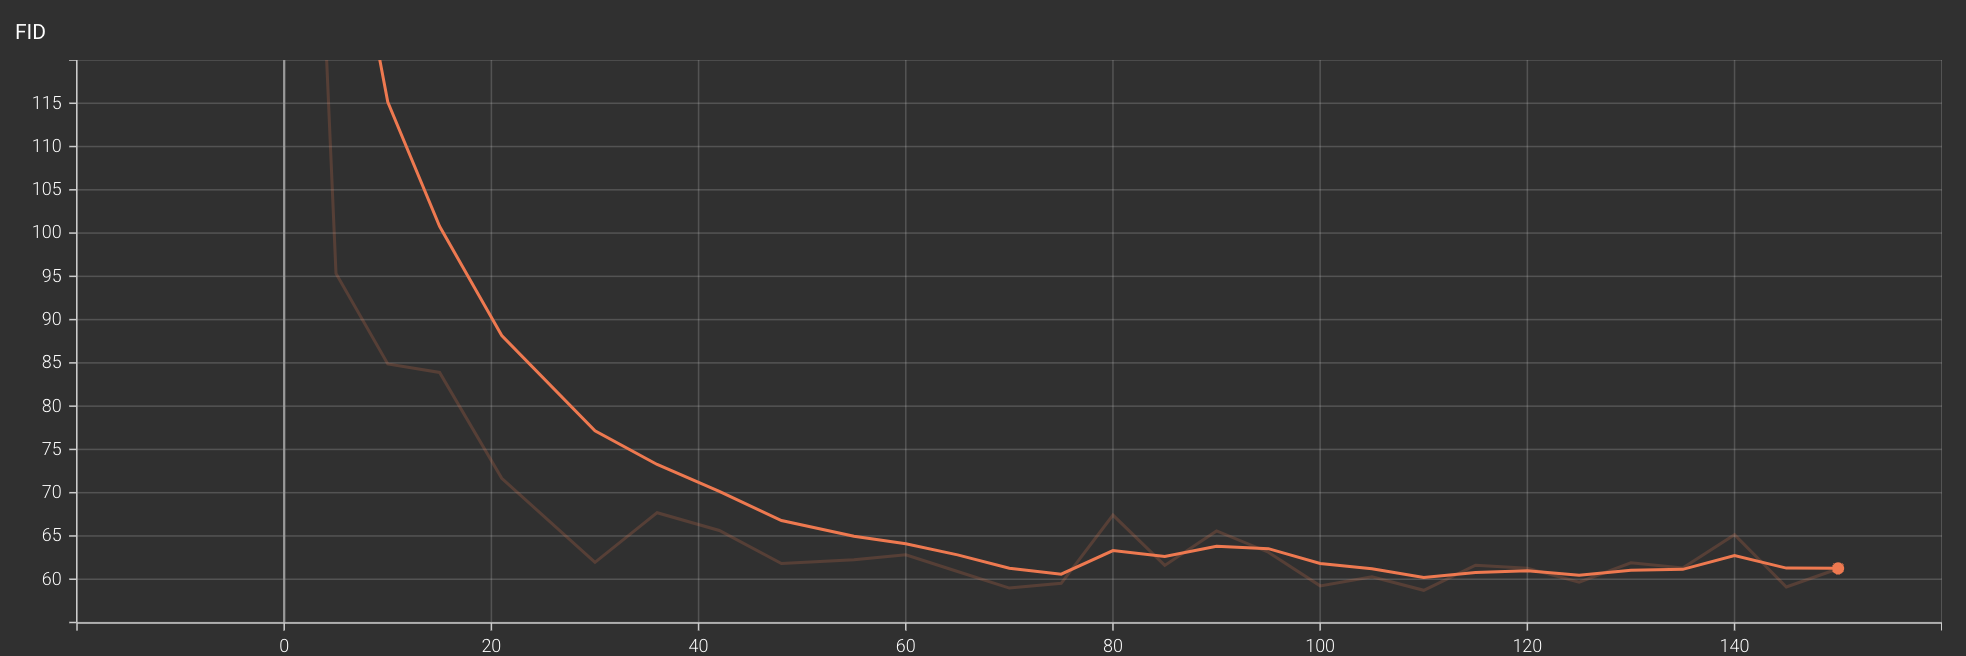

## So we checked for 150 epoch and the FID was not going down anymore, we still tried to train up till 225th epoch but FID was kindof same. This is where we stopped completely.

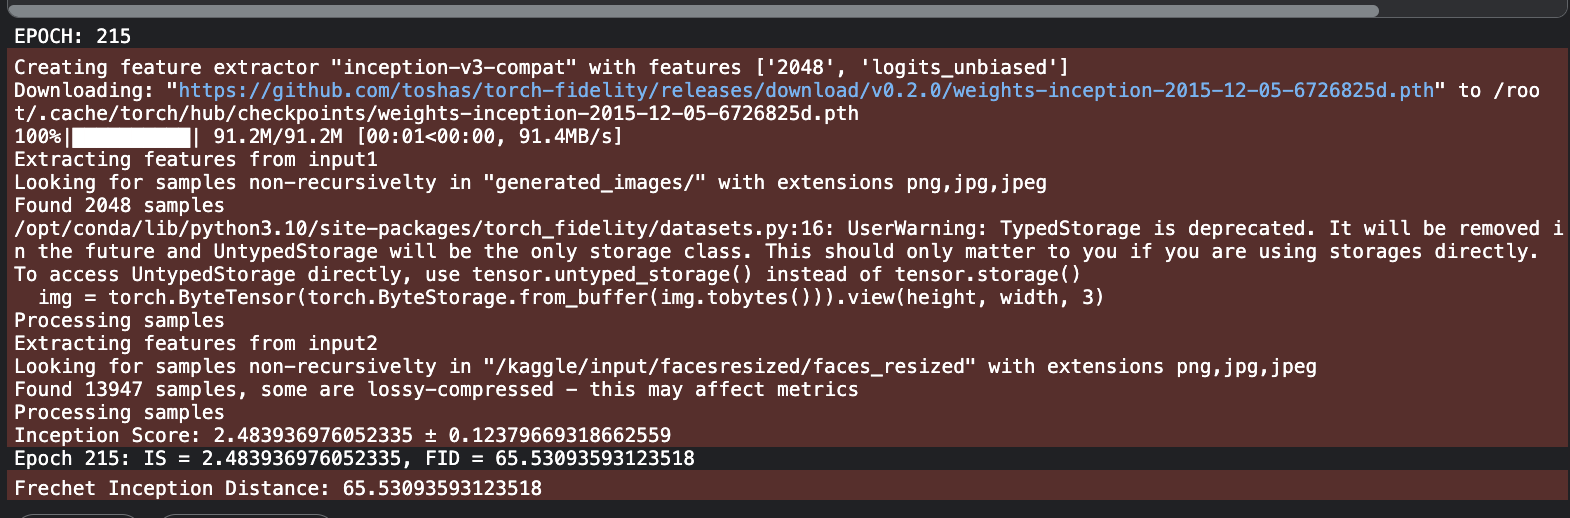

## The weights are in expected distribution of zero centric and sd of 0.2!

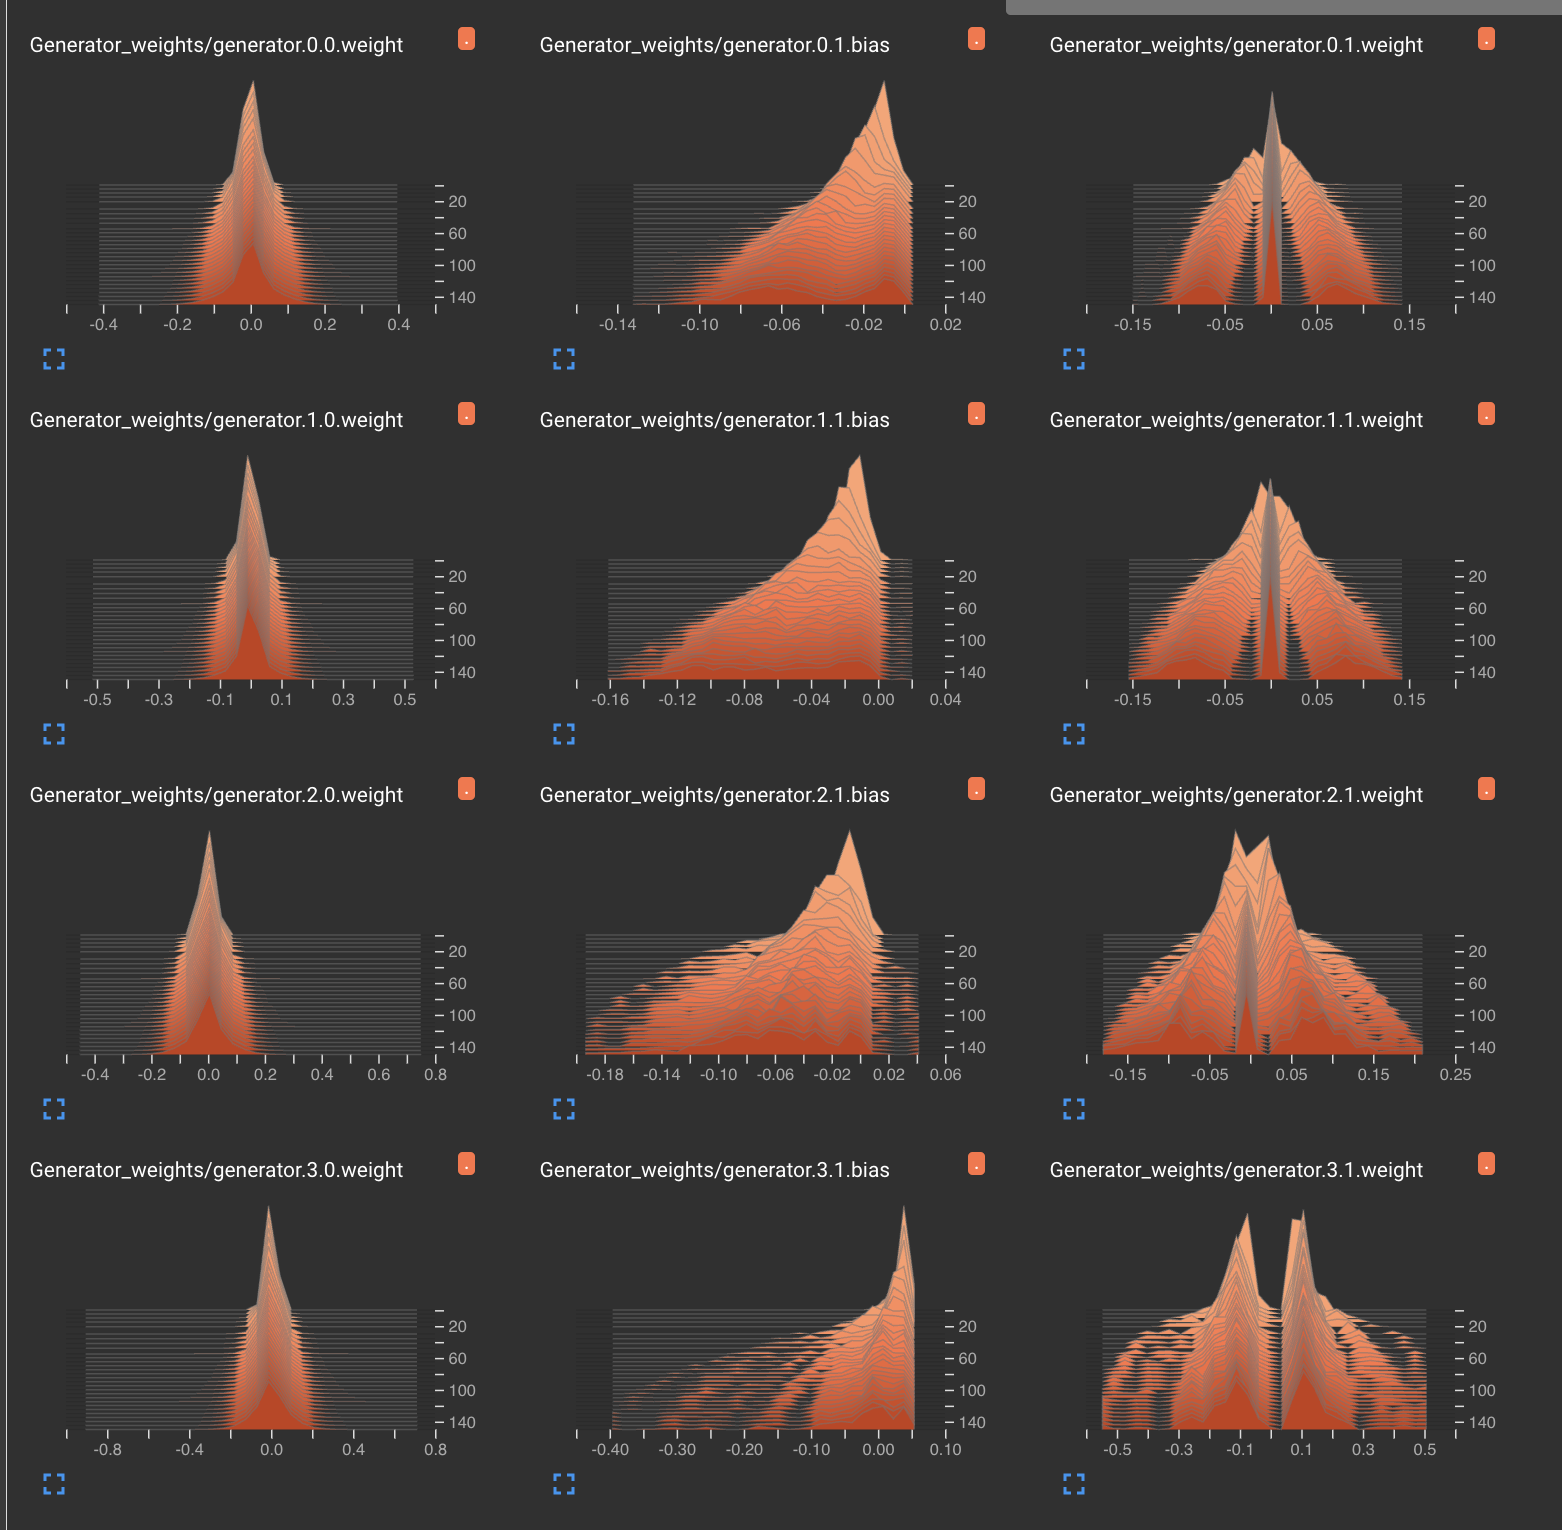

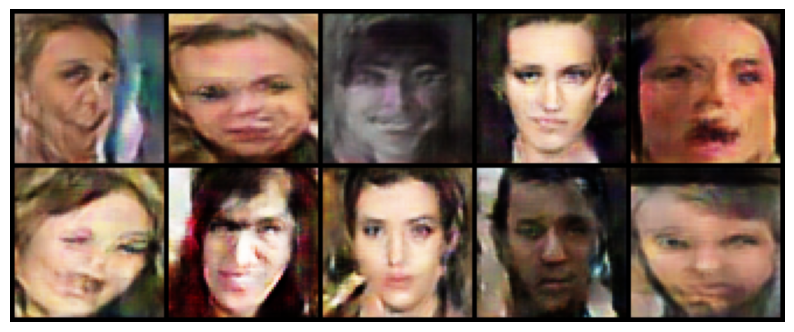

In [154]:
checkpoint_path = '/kaggle/working/ckpts/checkpoint_epoch_225.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)
my_generator.load_state_dict(checkpoint['generator_state_dict'])

my_generator.eval()

noise_dim = 100  
num_images = 10

noise = torch.randn(num_images, noise_dim, 1, 1, device=device)

save_dir = 'gen_faces'
os.makedirs(save_dir, exist_ok=True)

with torch.no_grad():
    fake_images = my_generator(noise)

fake_images_grid = make_grid(fake_images, nrow=5, normalize=True).cpu()
plt.figure(figsize=(10, 5))
plt.imshow(fake_images_grid.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()


### We tried to use LR exponential scheduler to slowly decrease the learning rate, but it did not seem to effect the model by much, we tried different batch sizes, same results.

## Eventhough the FID score is in same range, the faces from higher epoch seem to be getting better. More training? 

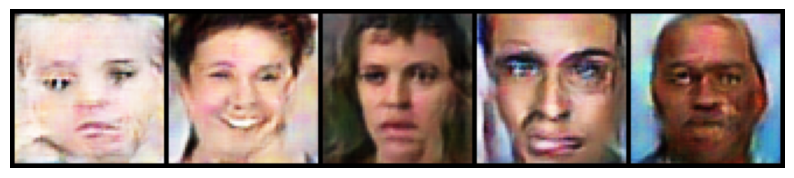

In [43]:
checkpoint_path = '/kaggle/working/ckpts/checkpoint_epoch_215.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)
my_generator.load_state_dict(checkpoint['generator_state_dict'])

my_generator.eval()

noise_dim = 100  
num_images = 5

noise = torch.randn(num_images, noise_dim, 1, 1, device=device)

save_dir = 'gen_faces'
os.makedirs(save_dir, exist_ok=True)

with torch.no_grad():
    fake_images = my_generator(noise)

fake_images_grid = make_grid(fake_images, nrow=5, normalize=True).cpu()
plt.figure(figsize=(10, 5))
plt.imshow(fake_images_grid.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

# References:
- https://github.com/bioinf-jku/TTUR/issues/4
- https://github.com/bioinf-jku/TTUR/issues/4
- https://stackoverflow.com/questions/57814535/assertionerror-torch-not-compiled-with-cuda-enabled-in-spite-upgrading-to-cud
- https://stackoverflow.com/questions/55511857/how-to-load-the-gpu-trained-model-into-the-cpu
- https://ai.stackexchange.com/questions/26832/what-to-do-with-a-gan-that-trained-well-but-got-worse-over-time
- https://tungmphung.com/deep-learning-normalization-methods/#:~:text=Note%20that%20the%20major%20difference,and%20normalize%20inside%20each%20group.
- https://stackoverflow.com/questions/76688141/how-to-upload-checkpoint-to-kaggle
- https://wandb.ai/wandb_fc/LayerNorm/reports/Layer-Normalization-in-Pytorch-With-Examples---VmlldzoxMjk5MTk1
- https://stackoverflow.com/questions/70065235/understanding-torch-nn-layernorm-in-nlp
- https://towardsdatascience.com/demystified-wasserstein-gans-wgan-f835324899f4
- https://www.kaggle.com/code/ritvik1909/wasserstein-gan-with-gradient-penalty
- https://www.mathworks.com/help/deeplearning/ug/trainwasserstein-gan-with-gradient-penalty-wgan-gp.html
- https://www.mlq.ai/wasserstein-gans-with-gradient-penalty/
- https://stackoverflow.com/questions/71487645/gradient-penalty-in-wgan-gp
- https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490
- https://github.com/Mohammad-Rahmdel/WassersteinGAN-GradientPenalty-Tensorflow
- https://stackoverflow.com/questions/71689095/how-to-solve-the-pytorch-runtimeerror-numpy-is-not-available-without-upgrading
- https://github.com/googlecolab/colabtools/issues/4344
- https://saturncloud.io/blog/how-to-initialize-weights-in-pytorch-a-guide-for-data-scientists/#4-he-initialization
- https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
- https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/
- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- https://www.kaggle.com/code/hemantgahnolia/face-generation-using-wgan-pytorch
- https://www.kaggle.com/code/yogeshrampariya/wgan-to-regenerate-celeb-faces-using-pytorch
- https://www.youtube.com/watch?v=IZtv9s_Wx9I&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=4
- https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/4.%20WGAN-GP/model.py
- https://www.alexirpan.com/2017/02/22/wasserstein-gan.html
- https://arxiv.org/pdf/1704.00028.pdf
- https://arxiv.org/abs/1701.07875
- https://arxiv.org/pdf/1511.06434.pdf
- https://www.youtube.com/watch?v=pG0QZ7OddX4&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=5
- https://torch-fidelity.readthedocs.io/en/latest/
- https://www.reddit.com/r/pytorch/comments/v6h8ul/how_does_the_torchvisiontransformsnormalize_deal/
- https://github.com/junyanz/CycleGAN/issues/125
- https://github.com/pytorch/examples/issues/790
- https://proceedings.neurips.cc/paper_files/paper/2017/file/892c3b1c6dccd52936e27cbd0ff683d6-Paper.pdf
- https://stackoverflow.com/questions/76616042/attributeerror-module-pil-image-has-no-attribute-antialias
- https://datascience.stackexchange.com/questions/69506/inception-score-is-and-fr%C3%A9chet-inception-distance-fid-which-one-is-better-f

